# CPSC 452 Final Project

Team: Tristan Brigham, Eugene Han, Elder Veliz

## Setup

In [2]:
# standard library imports
import copy
import os
import sys
import time
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# local imports
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
from src.airfoil_gan import Coeff_Validator, Discriminator, EarlyStopping, Generator, OutputFormatter
from src.simulations import XfoilSimulator

In [3]:
# Define constants
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

RANDOM_INPUT_NUM = 512          # number of random points that we pass to the generator network
NUM_POINTS_POINT_CLOUD = 100    # the number of data points that describe each of the point clouds
COEFF_UPPER = 2                 # the upper and lower limits for the coefficients (abs val)
TRAINING_RATIO = 0.9            # the amount of data that we are going to use for training
SKIP_EVAL_EPOCHS = 100          # the number of epochs to skip between discriminator evaluations
BATCH_SIZE = 256
WINDOW_VAL = 7
BEZIER_VAL = 49
TRAIN_MODEL = False             # whether we should train the model this iteration or not
NORMAL_SMOOTH = False           # what kind of smoothing we should use
BEZIER_SMOOTH = True            # what kind of smoothing we should use
VERBOSE = True

print("Device: ", DEVICE)

Device:  cuda


We recommend leaving `TRAIN_MODEL` set to `False` as fully training the GAN takes a very long time.

## Data Loading

In [3]:
def get_points_from_dat_file(file_path):
	with open(file_path, 'r') as file:
		lines = file.readlines()

	# filter out non-numeric lines and strip whitespace
	points = []
	for line in lines:

		# segment the line
		parts = line.strip().split()

		# split the line and iterate through the parts
		if len(parts) == 2:
			try:
				points.append((float(parts[0]), float(parts[1])))
			except ValueError:
				print(f"Skipping invalid line: {line}")
				pass

	return points


# pull data tensor and information
# from a single folder that has all of the data inside of it
def get_folder_data(subdir):

    # pull the data tensor
    dat_path = os.path.join(os.path.dirname("__file__"), "..", "data", subdir, f"{subdir}_reformatted.dat")
    points = get_points_from_dat_file(dat_path)

    # get the tensor
    points = np.array(points)

    # get the other parameters that we want
    polar_path = os.path.join(os.path.dirname("__file__"), "..", "data", subdir, "polar.txt")
    resulting_data = pd.read_csv(polar_path, sep='\s+', skiprows=10)
    resulting_data = resulting_data.drop(0)

    # pulling individual values
    alpha = float(resulting_data["alpha"].loc[1].replace("*", ''))   
    CL = float(resulting_data['CL'].loc[1].replace("*", ''))            
    CD = float(resulting_data['CD'].loc[1].replace("*", ''))           
    CDp = float(resulting_data['CDp'].loc[1].replace("*", ''))            
    CM = float(resulting_data['CM'].loc[1].replace("*", ''))     

    # create labels tensor
    labels = np.array([CL, CDp, CM])

    # if any of the values are out of range then kill this example
    if any(np.abs(labels) > COEFF_UPPER):
        raise ValueError("Coefficient Bounds Violated")
	
    if(np.abs(np.array(points)) > 1).any():
        print("POINTS")

    # returning the generated values
    return (points, labels)


# define a function to create the tensors that we need
def pull_airfoil_data():

    # the lists we will return
    ret_data_tensor = []
    ret_labels_tensor = []

    # iterate through all of the potential airfoils
    data_folder = os.path.join(os.path.dirname("__file__"), "..", "data")
    for subdir in os.listdir(data_folder):
        try:
            # pull the data
            t_data, t_labels = get_folder_data(subdir)

        except Exception as e:
            if VERBOSE:
                print(f"{subdir} : {e}")
            continue

        # add the data to the list
        ret_data_tensor.append(t_data)
        ret_labels_tensor.append(t_labels)

    # convert it to a numpy array
    ret_data_tensor = np.array(ret_data_tensor)
    ret_labels_tensor = np.array(ret_labels_tensor)

    print(f"\n\nret_data_tensor_shapes shapes: {ret_data_tensor.shape}")
    print(f"ret_labels_tensor_shapes shapes: {ret_labels_tensor.shape}")

    # change the final versions to tensors
    ret_data_tensor = torch.Tensor(ret_data_tensor)
    ret_labels_tensor = torch.Tensor(ret_labels_tensor)

    return ret_data_tensor, ret_labels_tensor


# the data sets are going to be formed of:
# (1) 100-dimensional vector representing the input airfoil
# (2) 3-dimensional vector representing the label coefficient, drag-pressure coefficient, and moment coefficient
airfoil_data, label_values = pull_airfoil_data()

a18 : Coefficient Bounds Violated
ah63k127 : Coefficient Bounds Violated
ah83150q : Coefficient Bounds Violated
ah93k132 : Coefficient Bounds Violated
b707d : Coefficient Bounds Violated
b737a : Coefficient Bounds Violated
b737b : could not convert string to float: '0.000001740.48963'
bacj : Coefficient Bounds Violated
be50 : Coefficient Bounds Violated
coanda1 : Coefficient Bounds Violated
coanda2 : Coefficient Bounds Violated
coanda3 : Coefficient Bounds Violated
daytonwright6 : Coefficient Bounds Violated
dga1138 : Coefficient Bounds Violated
doa5 : Coefficient Bounds Violated
dsma523a : Coefficient Bounds Violated
e1233 : could not convert string to float: '0.000002620.32015'
e266 : Coefficient Bounds Violated
e325 : could not convert string to float: '0.000007198.97735'
e331 : could not convert string to float: '0.000008834.99226'
e332 : could not convert string to float: '2.000-139.7769'
e333 : could not convert string to float: '2.000-380.3700'
e334 : Coefficient Bounds Violated

In [4]:
# get the shapes to store them
airfoil_data_shape = airfoil_data.shape
label_values_shape = label_values.shape

# change the shape of the airfoil data
airfoil_data_copy = copy.copy(airfoil_data)
airfoil_data = airfoil_data_copy.view(-1, NUM_POINTS_POINT_CLOUD * 2)

print(f"RANDOM_INPUT_NUM: {RANDOM_INPUT_NUM}")

# creating the datasets
total_dataset = TensorDataset(torch.tensor(airfoil_data, dtype=torch.float32), torch.tensor(label_values, dtype=torch.float32))

train_dataset, test_dataset = random_split(total_dataset, [TRAINING_RATIO, 1 - TRAINING_RATIO])

# the train and the test for the data loader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"train_dataloader: {len(train_dataloader) * len(next(iter(train_dataloader))[0])}")
print(f"test_dataloader: {len(test_dataloader) * len(next(iter(test_dataloader))[0])}")

print()

print(f"dataloader: {next(iter(train_dataloader))[0].shape}")
print(f"dataloader: {next(iter(train_dataloader))[1].shape}")
print(f"dataloader: {next(iter(test_dataloader))[0].shape}")
print(f"dataloader: {next(iter(test_dataloader))[1].shape}")

RANDOM_INPUT_NUM: 512
train_dataloader: 288
test_dataloader: 28

dataloader: torch.Size([32, 200])
dataloader: torch.Size([32, 3])
dataloader: torch.Size([28, 200])
dataloader: torch.Size([28, 3])


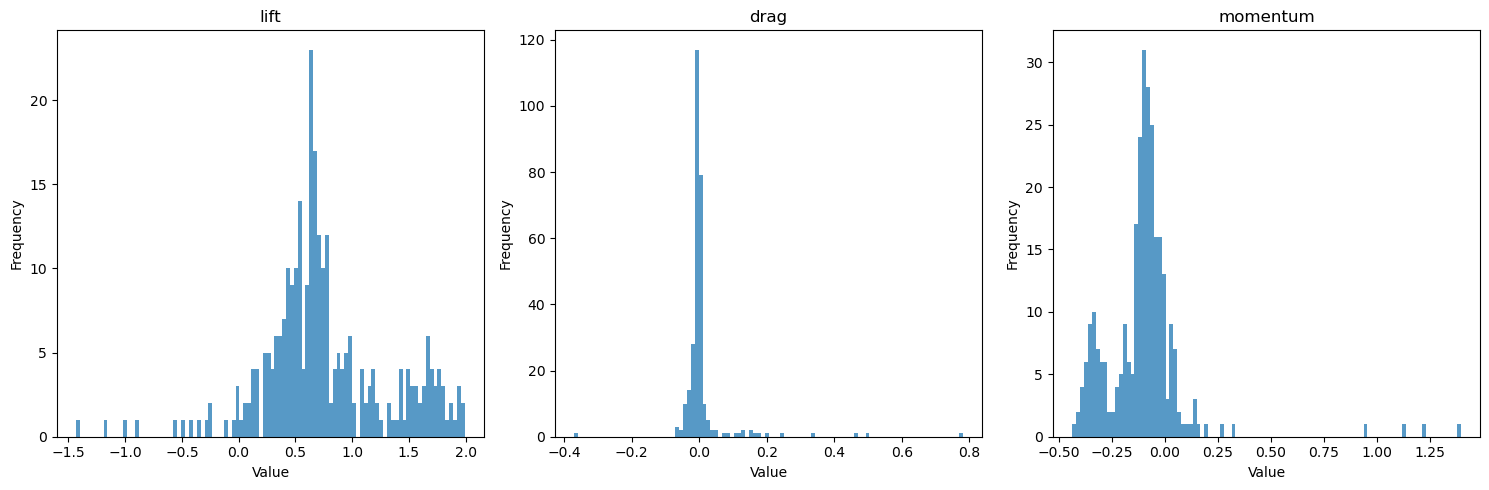

In [5]:
# plot the labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  

titles = ['lift', 'drag', 'momentum']

# Plotting each element across the batch
for i in range(3):
    axes[i].hist(label_values[:, i], bins = 100, alpha=0.75, )  # Plot element i across all batches
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Model Training

### Pre-Train Parameter-Specific Discriminators

In [6]:
# function for initializing the weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# create the models
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# initialize the weights 
generator.apply(weights_init)
discriminator.apply(weights_init)

# create optimizers for the generator and discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000001)

# function to create noise
def generate_noise(size):
    return torch.randn(size, RANDOM_INPUT_NUM).to(DEVICE)

# this is a function that initializes and creates the validator objects that we are going to use
# in order to train the GAN. These weights will not change
def initialize_validators():

    # initialize the number of discriminators that we need for the number of labels that we pull
    validator_dict = {
        'lift': Coeff_Validator().to(DEVICE),
        'drag': Coeff_Validator().to(DEVICE),
        'momentum': Coeff_Validator().to(DEVICE)
    }

    optimizer_dict = {
        'lift': None,
        'drag': None,
        'momentum': None
    }

    for disc_name, disc_object in validator_dict.items():
        
        # initialize a discriminator
        validator_dict[disc_name] = validator_dict[disc_name].apply(weights_init)

        # create the optimizer
        optimizer_dict[disc_name] = optim.Adam(
            validator_dict[disc_name].parameters(), 
            lr=0.0002, 
            betas=(0.5, 0.999)
        )

    return validator_dict, optimizer_dict

# define a function that is going to pre-train the validators
# these are going to be used in place of CFD for inside of the training function for the sake of time 
# they will output the coefficient value that they think is right for some input point cloud
def train_validators(epochs, data_loader, test_loader, validator_dict, optimizer_dict):

    # create the loss function
    loss_function = nn.MSELoss()
    
    # keeping track of the total loss
    loss_dict = {}

    # iterate through the discriminators to update the parameters
    for disc_name, disc_object in validator_dict.items():

        # initalize an early stopping value for this validator
        ckpt_path = os.path.join(os.path.dirname("__file__"), "..", "models", f"{disc_name}_best.ckpt")
        early_stop = EarlyStopping(patience=10, min_delta=0.01, saving_path=ckpt_path)

        print(f"\n\nTraining {disc_name}")

        # go for each of the epochs
        for epoch in range(epochs):

            # initialize zero for the discriminators
            loss_dict[disc_name] = 0
            disc_loss = 0
            
            # load the information
            for real_shapes, labels in data_loader:

                # move the labels to the device
                labels = labels.to(DEVICE)

                # reset the optimizer
                optimizer = optimizer_dict[disc_name]
                optimizer.zero_grad()

                # get the predictions
                predictions = disc_object(real_shapes).to(DEVICE)
                
                # backpropagate the loss
                loss = loss_function(predictions.to(DEVICE), labels.to(DEVICE))
                loss.backward()
                optimizer.step()
                
                # add the loss
                disc_loss += loss


            # compute the validation loss
            disc_object.eval()
            test_loss = 0

            with torch.no_grad():

                # go through the test loader and compute the loss
                for data, labels in test_loader:

                    # update the loss value
                    labels = labels.to(DEVICE)
                    predictions = disc_object(data).to(DEVICE)
                    test_loss += loss_function(predictions, labels)

            # normalize the test loss
            test_loss /= len(test_loader)
            loss_dict[disc_name] = test_loss

            # print the epoch ever so often
            if epoch % 5 == 0:
                print(f'Epoch {epoch}/{epochs} | Train Loss: {(disc_loss / len(data_loader)):.4f} | Test Loss: {(test_loss):.4f}')
                
            # check for early stopping
            early_stop(test_loss, disc_object)

            # check for early stopping
            if early_stop.early_stop:
               
                print("Early stopping")

                # print the epoch
                print(f'\nEpoch {epoch}/{epochs} | Loss: {(early_stop.b_loss):.4f}')

                early_stop.load_checkpoint(validator_dict[disc_name])
                break
            
    print(f"\nDONE TRAINING\n")       
    for key, loss_val in loss_dict.items():
        print(f'Training Loss {key}: {(loss_val / len(data_loader)):.4f}')

    # return the validator and optimizer dictionaries
    return validator_dict, optimizer_dict

# now create the validators
validator_dict, optimizer_dict = initialize_validators()

# now train the validators
if TRAIN_MODEL:
    validator_dict, optimizer_dict = train_validators(100, train_dataloader, test_dataloader, validator_dict, optimizer_dict)



Training lift
Epoch 0/100 | Train Loss: 0.4661 | Test Loss: 0.2580
Lower Validation Loss (0.258009 --> 0.258009)
Lower Validation Loss (0.258009 --> 0.247992)
Epoch 5/100 | Train Loss: 0.2920 | Test Loss: 0.2457
Lower Validation Loss (0.247992 --> 0.237276)
Epoch 10/100 | Train Loss: 0.2928 | Test Loss: 0.2318
Lower Validation Loss (0.237276 --> 0.226699)
Epoch 15/100 | Train Loss: 0.2774 | Test Loss: 0.2201
Lower Validation Loss (0.226699 --> 0.216176)
Epoch 20/100 | Train Loss: 0.2814 | Test Loss: 0.2149
Epoch 25/100 | Train Loss: 0.2609 | Test Loss: 0.2144
Early stopping

Epoch 28/100 | Loss: 0.2162


Training drag
Epoch 0/100 | Train Loss: 0.3527 | Test Loss: 0.2551
Lower Validation Loss (0.255121 --> 0.255121)
Lower Validation Loss (0.255121 --> 0.243003)
Epoch 5/100 | Train Loss: 0.2780 | Test Loss: 0.2402
Lower Validation Loss (0.243003 --> 0.232070)
Epoch 10/100 | Train Loss: 0.2658 | Test Loss: 0.2273
Lower Validation Loss (0.232070 --> 0.221368)
Epoch 15/100 | Train Loss: 0

### Train GAN

In [7]:
# make it so that the weights don't change anymore
# we will use these pre-trained discriminators later on
for mod_name, mod_obj in validator_dict.items():

    # turn off the parameters
    for param in mod_obj.parameters():

        # turn off the gradient
        param.requires_grad = False

def create_unique_file(base_path):
    dir, fname = os.path.split(base_path)
    bfname, ext = os.path.splitext(fname)

    i = 1
    new_file_path = os.path.join(dir, f"{bfname}_{i}{ext}")
    while os.path.exists(new_file_path):
        i += 1
        new_file_path = os.path.join(dir, f"{bfname}_{i}{ext}")
    return new_file_path

# training loop
def train_GAN(
    epochs, 
    batch_size, 
    train_dataloader, 
    test_dataloader, 
    training_status_file=os.path.join(os.path.dirname("__file__"), "..", "gan_output", "train_gan_output.txt")
):

    # init the loss values for the discriminator and the generator
    total_d_loss = 0
    total_g_loss = 0

    os.makedirs(os.path.join(os.path.dirname("__file__"), "..", "gan_output"), exist_ok=True)

    # open the file 
    write_file_path = create_unique_file(training_status_file)

    print(f"write_file_path: {write_file_path}")


    # get the starting time
    curr_start = time.time()

    # create the loss function
    validator_loss_function = nn.MSELoss()
    discriminator_loss_function = nn.BCELoss()

    # do it for some amount of epochs
    for epoch in range(epochs):

        if epoch % SKIP_EVAL_EPOCHS == 0:

            # go through the data in the data loader
            for i, (data, labels) in enumerate(train_dataloader):

                # reset the labels
                labels = torch.tensor(np.array(labels)).clone().detach().to(DEVICE)

                # set the gradients to zero
                optimizer_G.zero_grad()
                optimizer_D.zero_grad()

                # generating random noise
                random_noise = generate_noise(len(labels)).to(DEVICE)

                # get the model output
                generator_output = generator(random_noise, labels)

                # add the losses together
                output_lift = validator_dict['lift'](generator_output)
                output_drag = validator_dict['drag'](generator_output)
                output_momentum = validator_dict['momentum'](generator_output)

                # compute the losses
                loss_lift = validator_loss_function(output_lift, labels[:, 0].unsqueeze(1))
                loss_drag = validator_loss_function(output_drag, labels[:, 1].unsqueeze(1))
                loss_momentum = validator_loss_function(output_momentum, labels[:, 2].unsqueeze(1))

                # combine the loss functions together
                total_loss_model = 1.0 * loss_lift + 0.1 * loss_drag + 0.7 * loss_momentum

                # backwards propagate the loss
                total_loss_model.backward()

                # increment the optimizer
                optimizer_G.step()

                optimizer_G.zero_grad()
                optimizer_D.zero_grad()


            total_loss_model = total_loss_model / len(train_dataloader)

        else:

            total_loss_model = 0

        total_d_loss = 0
        total_g_loss = 0

        # now train the model with the GAN strategy
        for i, (data, labels) in enumerate(train_dataloader):

            # reset the labels
            labels = torch.tensor(np.array(labels)).clone().detach().to(DEVICE)

            # set the gradients to zero
            optimizer_G.zero_grad()
            optimizer_D.zero_grad()

            real_labels = torch.ones(len(labels), 1).to(DEVICE)
            fake_labels = torch.zeros(len(labels), 1).to(DEVICE)

            # generating random noise
            random_noise = generate_noise(len(labels)).to(DEVICE)

            # get the model output
            fake_airfoils = generator(random_noise, labels)

            # get the discriminator output
            fake_output = discriminator(fake_airfoils)
            
            # now compare it with the real airfoils
            fake_loss = discriminator_loss_function(fake_output, fake_labels)

            # get the real loss
            real_output = discriminator(data)

            # real loss check now
            real_loss = discriminator_loss_function(real_output, real_labels)

            # compute the gradients
            d_loss = 0.5 * real_loss + 0.5 * fake_loss
            
            # step the loss function
            d_loss.backward(retain_graph=True)
            total_d_loss += d_loss
            
            # step the optimization function by one
            optimizer_D.step()

            # step the loss function
            random_noise = generate_noise(len(labels)).to(DEVICE)
            fake_airfoils = generator(random_noise, labels)
            g_loss = discriminator_loss_function(discriminator(fake_airfoils), real_labels)
            
            g_loss.backward()
            optimizer_G.step()
            total_g_loss += g_loss


        total_d_loss = total_d_loss / len(train_dataloader)        
        total_g_loss = total_g_loss / len(train_dataloader)     

        if epoch % SKIP_EVAL_EPOCHS == 0:

            # create a string for the status output
            status_output = f'{epoch}/{epochs} | {(time.time() - curr_start):.4f} seconds | loss_lift: {loss_lift.item():.4f} | loss_drag: {loss_drag.item():.4f} | loss_momentum: {loss_momentum.item():.4f} | d_loss: {total_d_loss:.4f} | g_loss: {total_g_loss:.4f}'

            # write the status output to the file
            with open(write_file_path, 'a') as write_file:
                write_file.write(status_output + '\n')

            print(status_output)

            curr_start = time.time()

            torch.save(
                generator.state_dict(),
                os.path.join(
                    os.path.dirname("__file__"),
                    "..",
                    "models",
                    "checkpoints",
                    f"generator_{epoch}.ckpt",
                ),
            )
            torch.save(
                discriminator.state_dict(),
                os.path.join(
                    os.path.dirname("__file__"),
                    "..",
                    "models",
                    "checkpoints",
                    f"discriminator_{epoch}.ckpt",
                ),
            )
            for disc_name, disc_object in validator_dict.items():
                torch.save(
                    discriminator.state_dict(),
                    os.path.join(
                        os.path.dirname("__file__"),
                        "..",
                        "models",
                        "checkpoints",
                        f"{disc_name}_{epoch}.ckpt",
                    ),
                )

        # save the model every 1000 epochs or so
        if epoch % 1000 == 0:
            # get the model output
            random_noise = generate_noise(1)
            input_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(DEVICE)
            input_noise = random_noise.to(DEVICE)
            gen_points = generator(input_noise, input_label)

            status_output = f'''
                Max: {max(gen_points[0])}
                Min: {min(gen_points[0])}
                Fake Disc Score: {discriminator(gen_points)}
                True Disc Score: {discriminator(next(iter(test_dataloader))[0][0])}
            '''

            with open(write_file_path, 'a') as write_file:
                write_file.write(status_output + '\n')

            print(status_output)

if TRAIN_MODEL:
    train_GAN(epochs=100000, batch_size=256, train_dataloader=train_dataloader, test_dataloader=test_dataloader)

## Airfoil Generation and Evaluation

In [8]:
# load the best generator model
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load(f"../models/generator_best.ckpt", map_location=torch.device(DEVICE)))
generator.eval()

Generator(
  (fc): Sequential(
    (0): Linear(in_features=515, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=256, out_features=200, bias=True)
  )
)

In [9]:
# load the best discriminator model
discriminator = Discriminator().to(DEVICE)
discriminator.load_state_dict(torch.load(f"../models/discriminator_best.ckpt", map_location=torch.device(DEVICE)))
discriminator.eval()

Discriminator(
  (fc): Sequential(
    (0): Linear(in_features=200, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### Create and Plot Example of Generated Airfoil

label_target: tensor([[0.5000, 0.0000, 0.0000]], device='cuda:0')
random_noise: torch.Size([1, 3])
label_values: torch.Size([1, 512])
Max: 1.0360698699951172
Min: -0.10852347314357758
tensor([[0.5157]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.6018], device='cuda:0', grad_fn=<SigmoidBackward0>)
ADDING: 100
point_array len: 198
max_x_idx: 100
min_x_idx: 0
delta_back: -0.002373329553841355
delta_front: -0.012663714627044857
back_y: 0.029864072229741745
front_y: 0.03595632797656996
xl: 100
yl: 100
xu: 100
yu: 100


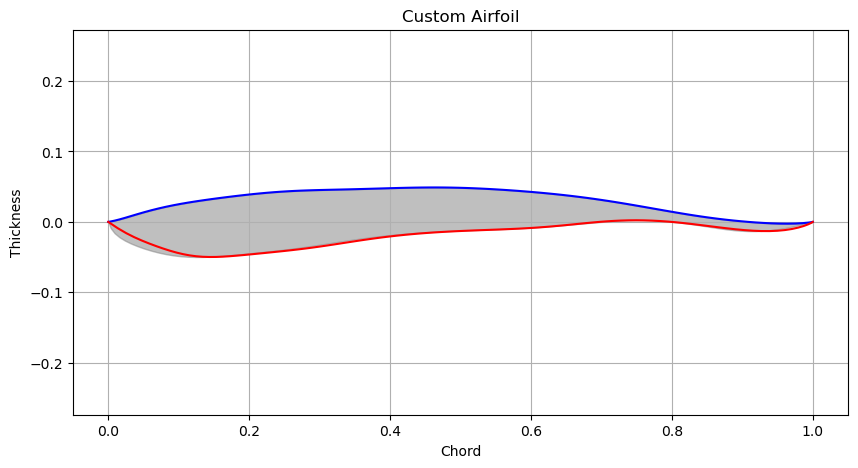

In [16]:
# generating random noise
random_noise = generate_noise(1)

ex_label = torch.tensor(np.array(label_values[0])).unsqueeze(0).to(DEVICE)
ex_label = torch.tensor(np.array([0.5, 0.0, 0.0]), dtype=torch.float32).unsqueeze(0).to(DEVICE)
label_target = ex_label
print(f"label_target: {label_target}")

input_noise = random_noise.to(DEVICE)

print(f"random_noise: {label_target.shape}")
print(f"label_values: {input_noise.shape}")

# get the model output
gen_points = generator(input_noise, label_target)
print(f"Max: {max(gen_points[0])}")
print(f"Min: {min(gen_points[0])}")
print(discriminator(gen_points))
print(discriminator(next(iter(train_dataloader))[0][0]))


def save_foil_to_file(point_array, base_dir="./demo/"):
    os.makedirs("./demo", exist_ok=True)
    write_path = os.path.join(base_dir, "example_gen_foil.dat")
    
    # write the points to a file
    with open(write_path, 'w') as new_file:
        for x, y in point_array:
            new_file.write(f"{x:.6f} {y:.6f}\n")


# reformat generated points as they are extremely noisy
# plot the synthesized airfoil
formatter = OutputFormatter(verbose=VERBOSE, window_val=WINDOW_VAL, bezier_smooth=BEZIER_SMOOTH)
gen_point_array = formatter.show_airfoil(point_array=gen_points.detach().cpu().numpy()[0])
save_foil_to_file(gen_point_array)

### Simulate Generated Airfoil in XFOIL

WARNING: For Windows users, the following code will likely raise an error, as the formatting of the simulation output differs between Xfoil versions for Windows and Unix-based systems. We recommend running the code on a Unix-based system, as the outputs contain important information regarding material properties.

In [ ]:
xfoil_sim = XfoilSimulator(verbose=VERBOSE)
xfoil_sim.run_simulation("./demo", "./demo/example_gen_foil.dat")